# Homework06

Some exercises with image and audio data preparation.

## Goals

- Even more practice with lists
- Get familiar with pandas `DataFrames`
- Practice dataset exploration and normalization/scaling
- Set up a dataset for proper classification

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework

In [ ]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/audio_utils.py
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/image_utils.py

!wget -q https://github.com/PSAM-5020-2025F-A/Homework04/raw/main/Homework04_utils.pyc
!wget -q https://github.com/PSAM-5020-2025F-A/Homework05/raw/main/Homework05_utils.pyc

!wget -qO- https://github.com/PSAM-5020-2025F-A/5020-utils/releases/latest/download/forest-tree.tar.gz | tar xz
!wget -qO- https://github.com/PSAM-5020-2025F-A/5020-utils/releases/latest/download/instruments.tar.gz | tar xz

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from image_utils import make_image, get_pixels

from Homework06_utils import AwesomeAudioClassifier, AwesomeImageClassifier

AUDIO_PATH = "./data/audio/instruments/test"
IMAGE_PATH = "./data/image/forest-tree/test"

## More Image/Audio Classification

We're going to re-visit the classification exercises from `Homework04` and `Homework05`.

This exercise is a bit different though. In some ways it's the opposite of the previous exercises because we'll already have classification models ready to be used, but will have to normalize and standardize our dataset in order to run them. This is more representative of the type of work that goes into using real, pre-trained, ML models in the wild.

### The Models

We have two `Awesome` models, one for audio classification (`AwesomeAudioClassifier`), and one for image classification (`AwesomeImageClassifier`).

Unlike the classification models we set up for `Homework04` and `Homework05`, these models have more strict requirements about the shape and values of their input data. We can't run them on the files as they are.

### The Data

Audio and Image files are in the `data/audio/` and `data/image/` directories respectively.

We will use the `get_training_data()` from each of our classifiers to get the initial training data and labels for our audio and image files.

### The Features

This is the challenging part.

The data returned by `get_training_data()` is a representation of the content of the audio and image files, but it hasn't been processed or normalized in order to be used by the classifier models provided.

We can try to create a `DataFrame` directly from those, and it might seem like it works, but if we take a look at the result we'll see some `NaN` (Not-a-Number) values in some of the columns, and if we send that to the model it will barf and complain about having `NaN`s in the data.

This happens because all of the audios and images have different sizes. Hoooray !!

Welcome to Machine Learning. This is probably where most of the time in any ML project is spent: cleaning up data and making sure it has the right format, size and shape that a model expects.

For this exercise it won't be too hard to fix these.

Let's start with the audio files since they're one-dimensional, and once we have the audio modeling working we'll come back to the image files.

<div style="background:#040; padding:10px; width:calc(100% - 28px)">

## Audio Data

Let's run `AwesomeAudioClassifier.get_training_data()` function to get some audio data. This function returns audio data and labels from files inside a specified directory.

</div>

In [24]:
features, labels = AwesomeAudioClassifier.get_training_data(AUDIO_PATH)

### Audio Features

The audio data returned is actually in the frequency domain and is not samples, so even though we can't play these audio files, we can still plot this data and will have to normalize and clean it before we can run it through our classifier.

Let's take a look at this data.

What are the labels ? How many records do we have ? How many features do we have in each record ? Can we plot our data ?

the labels are: {'guitar', 'piano', 'clarinet'}
the amount of records is: 79
the records have from 43000 to 43543 features.


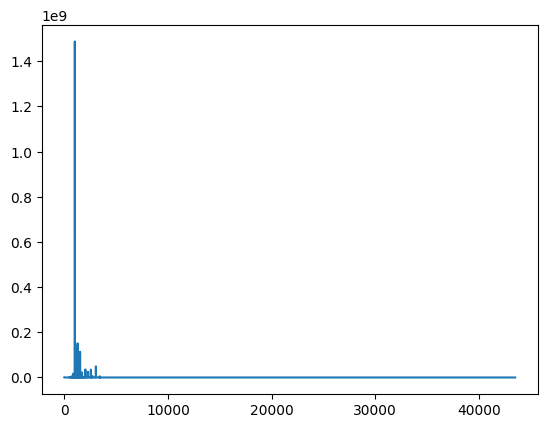

In [25]:
# TODO: How many records ?
print("the labels are:", set(labels))
print("the amount of records is:", len(labels))

# TODO: How many features ?
# the data is not yet structured as a dataframe, so we can not get the amount of features in each record by counting feature values in the first record
# (different records can have different amounts of features)
# creating a list of all the features length of all the records
features_lengths = [len(f) for f in features]
min_features = min(features_lengths)
max_features = max(features_lengths)
print("the records have from", min_features, "to", max_features, "features.")

# TODO: Plot some features
first_record_features = features[0]
plt.plot(first_record_features)

### Looks like data !

Looks like audio frequency-domain data to be more specific.

If we were to follow some of the data exploration steps we saw in class we would want to put this data in a `DataFrame` in order to get calculate some of its statistical properties, and maybe scale/normalize it before we use it in a classifier model.

Let's try it:

In [26]:
features_df = pd.DataFrame(features)
features_df

,0,1,2,3,4,5,6,7,8,9,...,43533,43534,43535,43536,43537,43538,43539,43540,43541,43542
0,365276.0,9142.0,15698.0,4560.0,2568.0,5337.0,8519.0,4561.0,2184.0,2310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,478.0,727.0,338.0,24.0,19.0,13.0,6.0,12.0,11.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16147157.0,2084192.0,682.0,155.0,547.0,53.0,8.0,2785.0,6829.0,645.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,900.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14136394.0,1554687.0,352.0,10.0,67.0,550.0,1933.0,1559.0,1288.0,164.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,16320957.0,3346669.0,8261.0,736.0,10.0,81.0,4.0,364.0,66.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,1398985.0,200202.0,11.0,18.0,19.0,4.0,0.0,10.0,77.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,55.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,97490.0,28472.0,476.0,4.0,0.0,0.0,6.0,0.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like it works, but when we look closely at the `DataFrame`, specially if we look at the features that are further to the right, we'll see our problem: `NaN` values.

As previously mentioned, this happens because the length of our features is different for each file.

### Fix Audio Data

Let's fix this by making all of the feature lists have the same length. We can either pad the short ones or slice the longer ones to have the same length as the shortest feature list. The second option is preferable since padding would require adding information to the dataset and that might have side effects.

So, we'll go through the lists of lists, create a list of lengths and find the smallest length.

Then, we'll iterate through the lists of lists and slice all the feature lists to have the same length.

In [27]:
# TODO: go through the list of features and make their lengths consistent
# creating an empty list to populate with lengths of features
features_length = []
for f in features:
    features_length.append(len(f))
print("features length:",features_length)

# finding the smallest length
smallest_length = min(features_length)
print("smallest length:", smallest_length)

# cropping the features longer than smallest_length and appending the cropped versions to a new list called cropped_features
cropped_features = []
for f in features:
    cropped_f = f[:smallest_length]
    cropped_features.append(cropped_f)
    
# checking the length of the first cropped feature, which should be 43000
print("length of the first cropped feature:",len(cropped_features[0]))

features length: [43511, 43376, 43235, 43057, 43281, 43540, 43087, 43360, 43259, 43219, 43150, 43216, 43043, 43265, 43510, 43104, 43503, 43181, 43028, 43173, 43171, 43146, 43011, 43280, 43265, 43297, 43511, 43275, 43296, 43345, 43411, 43401, 43485, 43384, 43536, 43144, 43050, 43510, 43419, 43541, 43543, 43515, 43106, 43189, 43271, 43416, 43219, 43180, 43155, 43388, 43234, 43499, 43038, 43304, 43246, 43271, 43136, 43429, 43000, 43270, 43432, 43365, 43057, 43206, 43520, 43364, 43165, 43248, 43298, 43028, 43277, 43393, 43200, 43027, 43175, 43520, 43189, 43047, 43529]
smallest length: 43000
length of the first cropped feature: 43000


A `DataFrame` created using the cropped features should look more consistent now.

In [28]:
features_df = pd.DataFrame(cropped_features)
features_df

,0,1,2,3,4,5,6,7,8,9,...,42990,42991,42992,42993,42994,42995,42996,42997,42998,42999
0,365276.0,9142.0,15698.0,4560.0,2568.0,5337.0,8519.0,4561.0,2184.0,2310.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,478.0,727.0,338.0,24.0,19.0,13.0,6.0,12.0,11.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16147157.0,2084192.0,682.0,155.0,547.0,53.0,8.0,2785.0,6829.0,645.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,900.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14136394.0,1554687.0,352.0,10.0,67.0,550.0,1933.0,1559.0,1288.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,16320957.0,3346669.0,8261.0,736.0,10.0,81.0,4.0,364.0,66.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,1398985.0,200202.0,11.0,18.0,19.0,4.0,0.0,10.0,77.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,55.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,97490.0,28472.0,476.0,4.0,0.0,0.0,6.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Bonus: Empty features

We've removed the `NaN` values, but it seems like we have a lot of columns that are all zeros or nearly all zeros.

While it's not necessary, we could also remove these in order to speed up the modeling later.

In [29]:
# sum of all columns
display(features_df.sum())

# columns where the sum is less than 100
display((features_df.sum(axis=0) < 100))

# TODO: remove columns with no information
# getting the columns that have nearly all zeros
columns_to_drop = features_df.columns[(features_df.sum(axis=0) < 100)]
# dropping those columns
features_df = features_df.drop(columns=columns_to_drop)

0        571268226.0
1         76106902.0
2            70758.0
3            16248.0
4            19507.0
            ...     
42995            1.0
42996            0.0
42997            0.0
42998            0.0
42999            1.0
Length: 43000, dtype: float64

0        False
1        False
2        False
3        False
4        False
         ...  
42995     True
42996     True
42997     True
42998     True
42999     True
Length: 43000, dtype: bool

### Run the Model

Now that we have a `DataFrame` with consistent rows, we can fit and evaluate our model.

The next cell runs the pre-defined classification model, fitting it with our `features_df` `DataFrame` and then reports the accuracy of our model.

We just have to run it.

In [30]:
# Fit the classifier and report training accuracy
AwesomeAudioClassifier.fit(features_df, labels)

training accuracy: {'clarinet': 0.71429, 'guitar': 0.7, 'piano': 1.0, 'overall': 0.80476}


### Scale / Normalize

Hmmm.... it runs, but we can do better.

We saw in class that normalizing/rescaling our features can help us find actual patterns in our data. It also helps models find patterns.

Try scaling the `DataFrame` using either a `MinMaxScaler` or a `StandardScaler` object.

In [31]:
# TODO: scale/normalize features

# creating a scaler object
# min_max_scaler = MinMaxScaler().set_output(transform="pandas")
std_scaler = StandardScaler().set_output(transform="pandas")

# applying the scaler object to our dataframe
# features_min_max_df = min_max_scaler.fit_transform(features_df)
features_scaled_df = std_scaler.fit_transform(features_df)

# this is the scaled version of the dataframe:
# features_min_max_df
features_scaled_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x8795,x8796,x8797,x8798,x8799,x8800,x8801,x8802,x8803,x8804
0,-0.426377,-0.432184,6.197049,6.727865,4.317511,8.571075,8.384447,4.431495,0.891889,5.948546,...,0.026961,2.583441,1.303717,-0.114391,-0.107187,-0.110229,-0.110477,-0.108695,-0.098286,8.369702
1,-0.449031,-0.435995,-0.233471,-0.280699,-0.423969,-0.203063,-0.184730,-0.436384,-0.493314,-0.165040,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117
2,0.553678,0.507628,-0.089454,-0.078291,0.558181,-0.137142,-0.182717,2.531000,3.852897,1.432521,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117
3,-0.449004,-0.436268,-0.374976,-0.317782,-0.459312,-0.224487,-0.190770,-0.449225,-0.500326,-0.316930,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117
4,0.428810,0.267810,-0.227610,-0.302331,-0.334683,0.681932,1.754986,1.219059,0.320724,0.127891,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.564471,1.079417,3.083522,0.819410,-0.440710,-0.090997,-0.186743,-0.059709,-0.458254,-0.254547,...,8.830648,-0.262461,-0.256793,8.831510,8.831728,8.831758,8.831760,8.831759,8.831748,-0.148117
75,-0.362183,-0.345651,-0.370371,-0.289970,-0.423969,-0.217895,-0.190770,-0.438524,-0.451242,-0.295232,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117
76,-0.449057,-0.436321,-0.374976,-0.317782,-0.459312,-0.224487,-0.190770,-0.449225,-0.500326,-0.316930,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117
77,-0.443006,-0.423429,-0.175697,-0.311601,-0.459312,-0.224487,-0.184730,-0.449225,-0.496502,-0.316930,...,-0.115034,-0.262461,-0.256793,-0.114391,-0.113731,-0.113390,-0.113338,-0.113347,-0.113422,-0.148117


### Run the Model Again

This time with scaled data.

In [32]:
# Fit the classifier and report training accuracy
AwesomeAudioClassifier.fit(features_scaled_df, labels)

training accuracy: {'clarinet': 0.90476, 'guitar': 0.9, 'piano': 1.0, 'overall': 0.93492}


### Interpretation

<span style="color:hotpink;">
Do different scaling strategies influence the prediction results ? What might that tell us about our data ?
</span>

<span style="color:hotpink;">
training accuracy with the minmax scaler: {'clarinet': 0.90476, 'guitar': 0.9, 'piano': 1.0, 'overall': 0.93492}

training accuracy with standard scaler: {'clarinet': 0.90476, 'guitar': 0.9, 'piano': 1.0, 'overall': 0.93492}

The MinMaxScaler transforms every feature to fit within a specific range (0 to 1), relative to the minimum and maximum values of that feature across all audio samples. Using this scaler on the DataFrame helps because it places all features on a comparable scale, preventing features with large ranges from dominating the model's training process. For instance, if one feature has values ranging from 0 to 100000000000 and another has values from 0 to 100, an unscaled model would base its decisions almost entirely on the differences in the first feature. It would nearly ignore the second one, even though that feature could be very useful for differentiating between instruments. When we scale the data, the model makes better decisions because it can evaluate all features on a level playing field.

A key difference between MinMaxScaler and StandardScaler is how they handle new data that falls outside the range of the original training set. If a new data point is outside the range seen during training, MinMaxScaler will transform it to a value greater than 1 or less than 0. This happens because the scaler's range is fixed based on the minimum and maximum of the initial data. StandardScaler, on the other hand, uses the mean and standard deviation for each column to center its values at 0 and have a range of about [-3, 3]. However, this output range is not technically fixed, so new data points can be scaled to any value. In this sense, it is less sensitive to outliers than MinMaxScaler.

In our case, the training accuracy improved significantly after scaling with both methods, which means that scaling was necessary. However, the prediction results did not change when using the two different scaling strategies, which suggests that the data does not have extreme outliers that would give one scaler an advantage over the other.</span>

<div style="background:#040; padding:10px; width:calc(100% - 28px)">

## Image Data

This is a bit trickier, but only because our classifier model for images is a bit pickier. Not only do we have to ensure that all of our records have the same number of features (images have the same number of pixels), we will also have to convert the pixels into grayscale pixels.

Let's start by reading the data and looking at what we get.

</div>

In [34]:
imgs, labels = AwesomeImageClassifier.get_training_data(IMAGE_PATH)

### Image Data

What did we get in the `imgs` variable ? How many records do we have ? How many features does each record/image have ?

In [35]:
# TODO: look at the imgs and labels variables and get some information about the data


# How many labels ?
print("the labels are:", set(labels))


# How many records ?
print("the amount of records is:", len(labels))


# How many features ?
# assuming that each pixel is a feature, we need to calculate the dimensions (height x width) of each image
# we can get this dimensions by getting the size of the image
features_imgs = []
for i in imgs:
    width, height = i.size
    num_pixels = width * height
    features_imgs.append(num_pixels)
min_features = min(features_imgs)
max_features = max(features_imgs)

print("the records have from",min_features, "to", max_features, "features (/pixels).")


the labels are: {'tree', 'forest', 'florist'}
the amount of records is: 127
the records have from 20164 to 64516 features (/pixels).


### Create Image Features

It seems like we have actual `PIL` image objects and their labels. 

This will work to our advantage because if we try to just create a `DataFrame` of the extracted pixels from these images we'll probably have a problem with missing feature values again.

In [36]:
features = []
for img in imgs:
  features.append(get_pixels(img))

print(len(features), len(features[0]), len(features[11]))

features_df = pd.DataFrame(features)
features_df

127 53824 34596


,0,1,2,3,4,5,6,7,8,9,...,64506,64507,64508,64509,64510,64511,64512,64513,64514,64515
0,"(217, 216, 222)","(221, 220, 226)","(223, 222, 228)","(220, 219, 225)","(217, 216, 222)","(219, 218, 224)","(219, 218, 224)","(218, 217, 223)","(213, 212, 218)","(214, 213, 219)",...,None,None,None,None,None,None,None,None,None,None
1,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)",...,None,None,None,None,None,None,None,None,None,None
2,"(150, 176, 79)","(114, 141, 46)","(124, 150, 60)","(81, 110, 25)","(79, 107, 28)","(121, 151, 77)","(104, 134, 68)","(63, 93, 32)","(75, 104, 45)","(86, 115, 57)",...,None,None,None,None,None,None,None,None,None,None
3,"(53, 106, 156)","(53, 106, 156)","(53, 106, 156)","(53, 106, 156)","(53, 106, 156)","(53, 106, 156)","(53, 106, 156)","(53, 106, 156)","(55, 108, 158)","(55, 108, 158)",...,None,None,None,None,None,None,None,None,None,None
4,"(82, 129, 147)","(53, 100, 118)","(55, 102, 119)","(66, 114, 128)","(56, 104, 118)","(55, 103, 115)","(72, 118, 128)","(72, 116, 124)","(53, 95, 101)","(63, 104, 108)",...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,"(22, 75, 187)","(22, 75, 187)","(22, 75, 187)","(22, 75, 187)","(22, 75, 187)","(22, 75, 187)","(22, 75, 187)","(22, 75, 187)","(23, 76, 188)","(23, 76, 188)",...,None,None,None,None,None,None,None,None,None,None
123,"(45, 49, 34)","(14, 20, 4)","(12, 24, 1)","(24, 43, 11)","(45, 69, 31)","(52, 81, 37)","(29, 65, 14)","(16, 58, 4)","(78, 122, 61)","(63, 107, 44)",...,None,None,None,None,None,None,None,None,None,None
124,"(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)","(255, 255, 255)",...,None,None,None,None,None,None,None,None,None,None
125,"(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)","(251, 248, 255)",...,None,None,None,None,None,None,None,None,None,None


### Fix Images

We could follow a similar approach to how we fixed the audio data, and just slice our pixel arrays to have the same length as the shortest pixel array, but that will distort our images. Try it out to see the result, but instead of taking pixels out from the end of the image, what we really have to do is change their dimensions so they all have the same `width` and `height` before we get their pixels.

There are a couple of ways to achieve this:
- Crop: use the `image.crop()` function to cut the images.
- Resize: use `image.resize()` to stretch/squeeze the images into specific shapes.

Documentation for [`crop()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop) and [`resize()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.resize).

Take a look at a few images before picking a strategy and then take a look after to see what the chosen strategy does to the images.

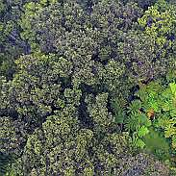

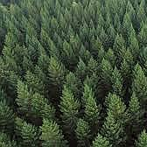

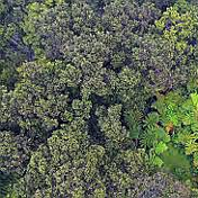

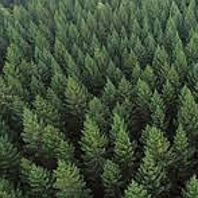

In [37]:
# TODO: look at characteristics/dimensions of the images

# looking at two random images before resizing
display(imgs[14])
display(imgs[8])

# getting all the widths and heights to calculate the average, which will be the size to which we are going to resize the images
widths = []
heights = []
for i in imgs:
  width, height = i.size
  widths.append(width)
  heights.append(height)
avg_width = int(sum(widths) / len(widths))
avg_height = int(sum(heights) / len(heights))

# TODO: go through the images and make their dimensions consistent
resized_imgs = []
new_size = (avg_width, avg_height)
for i in imgs:
   resized_img = i.resize(new_size)
   resized_imgs.append(resized_img)

# TODO: look at some images
display(resized_imgs[14])
display(resized_imgs[8])
# (they're bigger)

### Create Features

Now that we have images with consistent dimensions, we can extract their pixels and convert them to grayscale, so we get a nice looking `DataFrame` to send to our classifier model.

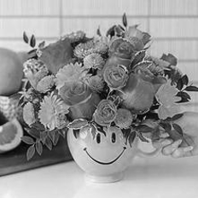

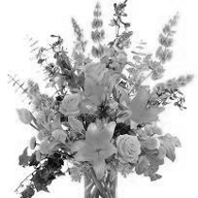

In [38]:
# TODO: calculate grayscale pixel values

grayscale_pixel_values = []
for img in resized_imgs:
    # getting the list of (R, G, B) pixels from the current image
    ipxs = list(img.getdata())
    bwpxs = []
    # calculating the grayscale value for each pixel
    for r,g,b in get_pixels(img):
      gval = (r + g + b) // 3
      bwpxs.append(gval)
    grayscale_pixel_values.append(bwpxs)
    

# TODO: look at some images with make_image()
w, h = resized_imgs[0].size
preview0 = make_image(grayscale_pixel_values[0], w, h)
display(preview0)

w, h = resized_imgs[1].size
preview1 = make_image(grayscale_pixel_values[1], w, h)
display(preview1)

# TODO: create DataFrame
features_df = pd.DataFrame(grayscale_pixel_values)

### Run the Image Model

Now that we have a `DataFrame` with consistent features, we can fit and evaluate our model.

The next cell runs the pre-defined classification model, fitting it with our `features_df` `DataFrame` and then reports the accuracy of our model.

We just have to run it (and wait a bit because it can take up to $20$ seconds for it to run).

In [39]:
# Fit the classifier and report training accuracy
AwesomeImageClassifier.fit(features_df, labels)

training accuracy: {'florist': 0.97917, 'forest': 1.0, 'tree': 0.825, 'overall': 0.93472}


### Scaling / Normalizing

Run the classifier model again, but this time using normalized features.

In [40]:
# TODO: create scaler object, scale data and re-run classification

# creating a scaler object
min_max_scaler = MinMaxScaler().set_output(transform="pandas")
# std_scaler = StandardScaler().set_output(transform="pandas")

# TODO: scale/normalize features

# applying the scaler object to our dataframe
features_min_max_df = min_max_scaler.fit_transform(features_df)
# features_scaled_df = std_scaler.fit_transform(features_df)

# this is the scaled version of the dataframe:
features_min_max_df
# features_scaled_df

# Fit the classifier and report training accuracy
AwesomeImageClassifier.fit(features_min_max_df, labels)
# AwesomeImageClassifier.fit(features_scaled_df, labels)


training accuracy: {'florist': 0.97917, 'forest': 1.0, 'tree': 0.825, 'overall': 0.93472}


### Interpretation

<span style="color:hotpink;">
Do different scaling strategies influence the prediction results ? What might that tell us about our data ?
</span>

<span style="color:hotpink;">
training accuracy with the minmax scaler: {'florist': 0.97917, 'forest': 1.0, 'tree': 0.825, 'overall': 0.93472}

training accuracy with the standard scaler: {'florist': 0.97917, 'forest': 1.0, 'tree': 0.85, 'overall': 0.94306}

The different scaling strategies did very slightly influence the prediction results, with StandardScaler performing marginally better overall. This slight improvement might indicate that centering the data around a mean of 0 was a little more effective than scaling it to a 0-1 range, but the fact that the results are so similar suggests that the data likely does not have significant outliers. </span>